## Accessing MODIS snow data with the Planetary Computer STAC API

The planetary computer hosts two snow-related MODIS 6.1 products:

- Snow cover daily (10A1)
- Snow cover 8-day (10A2)

For more information about the products themselves, check out the Data Pages at the [bottom of this document](#data-pages).

### Environment setup

This notebook works with or without an API key, but you will be given more permissive access to the data with an API key.
The Planetary Computer Hub is pre-configured to use your API key.

In [15]:
import odc.stac
import planetary_computer
from pystac_client import Client

Found existing installation: odc-stac 0.2.4
Uninstalling odc-stac-0.2.4:
  Successfully uninstalled odc-stac-0.2.4


### Query for available data

MODIS is a global dataset with a variety of products available within each larger category (vegetation, snow, fire, temperature, and reflectance).
The [MODIS group](https://planetarycomputer.microsoft.com/dataset/group/modis) contains a complete listing of available collections.
Each collection's id is in the format `modis-{product}-061`, where `product` is the MODIS product id.
The `-061` suffix indicates that all of the MODIS collections are part of the [MODIS 6.1 update](https://atmosphere-imager.gsfc.nasa.gov/documentation/collection-61).

We'll look at the snow cover around the Mount of the Holy Cross in Colorado and how it progresses throughout the winter, using the daily snow product (10A1).

In [23]:
longitude = -106.481687
latitude = 39.466829
mount_of_the_holy_cross = [longitude, latitude]
geometry = {
    "type": "Point",
    "coordinates": mount_of_the_holy_cross,
}
datetimes = [
    "2020-11",
    "2020-12",
    "2021-01",
    "2021-02",
    "2021-03",
    "2021-04",
    "2021-05",
    "2021-06",
]
items = dict()

catalog = Client.open("https://planetarycomputer-staging.microsoft.com/api/stac/v1")
for datetime in datetimes:
    print(f"Fetching {datetime}")
    search = catalog.search(
        collections=["modis-10A1-061"],
        intersects=geometry,
        datetime=datetime,
    )
    item = search.get_all_items()[0]
    items[datetime] = planetary_computer.sign(item)

print(items)

Fetching 2020-11
Fetching 2020-12
Fetching 2021-01
Fetching 2021-02
Fetching 2021-03
Fetching 2021-04
Fetching 2021-05
Fetching 2021-06
{'2020-11': <Item id=MYD10A1.A2020335.h09v05.061.2020357065201>, '2020-12': <Item id=MYD10A1.A2020366.h09v05.061.2021006153327>, '2021-01': <Item id=MYD10A1.A2021031.h09v05.061.2021033145105>, '2021-02': <Item id=MYD10A1.A2021059.h09v05.061.2021061192703>, '2021-03': <Item id=MYD10A1.A2021090.h09v05.061.2021092034817>, '2021-04': <Item id=MYD10A1.A2021120.h09v05.061.2021122125544>, '2021-05': <Item id=MYD10A1.A2021151.h09v05.061.2021153050114>, '2021-06': <Item id=MYD10A1.A2021181.h09v05.061.2021183182721>}


### Available assets

Each item has several available assets, including the original HDF file and a Cloud-optimized GeoTIFF of each subdataset.

In [32]:
item = items["2020-11"]
max_key_length = len(max(item.assets, key=len))
for key, asset in items["2020-11"].assets.items():
    print(f"{key.rjust(max_key_length)}: {asset.title}")

{'type': 'Feature', 'stac_version': '1.0.0', 'id': 'MYD10A1.A2020335.h09v05.061.2020357065201', 'properties': {'created': '2020-12-22T06:52:12Z', 'updated': '2020-12-22T02:13:41.398000Z', 'datetime': None, 'platform': 'aqua', 'proj:epsg': None, 'proj:wkt2': 'PROJCS["unnamed",GEOGCS["Unknown datum based upon the custom spheroid",DATUM["Not specified (based on custom spheroid)",SPHEROID["Custom spheroid",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["Meter",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]', 'proj:shape': [2400, 2400], 'instruments': ['modis'], 'end_datetime': '2020-11-30T23:59:59Z', 'modis:tile-id': '51009005', 'proj:geometry': {'type': 'Polygon', 'coordinates': [[[-8895604.157333, 3335851.559], [-8895604.157333, 4447802.078667], [-10007554.677, 4447802.078667], [-10007554.677, 3335851.559], [-88956

### Loading the snow cover data

For this example, we'll visualize and compare the snow cover month to month.
Let's grab each snow cover COG and load them into an xarray using [odc-stac](https://github.com/opendatacube/odc-stac).
We'll also apply the scaling as defined by the `raster:bands` extension.
The MODIS coordinate reference system is a [sinusoidal grid](https://modis-land.gsfc.nasa.gov/MODLAND_grid.html), which means that views in a naïve XY raster look skewed.
For visualization purposes, we reproject to a [spherical Mercator projection](https://wiki.openstreetmap.org/wiki/EPSG:3857) for intuitive, north-up visualization.

The NDSI Snow Cover values are defined as:

```
0–100: NDSI snow cover
200: missing data
201: no decision
211: night
237: inland water
239: ocean
250: cloud
254: detector saturated
255: fill
```

We want to mask out all numbers greater than 100.

In [43]:
bbox = [longitude - 0.5, latitude - 0.5, longitude + 0.5, latitude + 0.5]
data = odc.stac.load(
    items.values(),
    crs="EPSG:3857",
    bbox=bbox,
    bands="NDSI_Snow_Cover",
    resolution=500,
)
data = data.where(data <= 100, drop=True)
data

<xarray.Dataset>
Dimensions:          (time: 8, y: 290, x: 224)
Coordinates:
  * time             (time) datetime64[ns] 2020-11-30T11:59:59.500000 ... 202...
  * y                (y) float64 4.861e+06 4.861e+06 ... 4.717e+06 4.717e+06
  * x                (x) float64 -1.191e+07 -1.191e+07 ... -1.18e+07 -1.18e+07
    spatial_ref      int32 3857
Data variables:
    NDSI_Snow_Cover  (time, y, x) float64 nan nan nan nan ... nan nan nan nan
Attributes:
    crs:           EPSG:3857
    grid_mapping:  spatial_ref

### Displaying the data

Let's display the snow cover for each month.

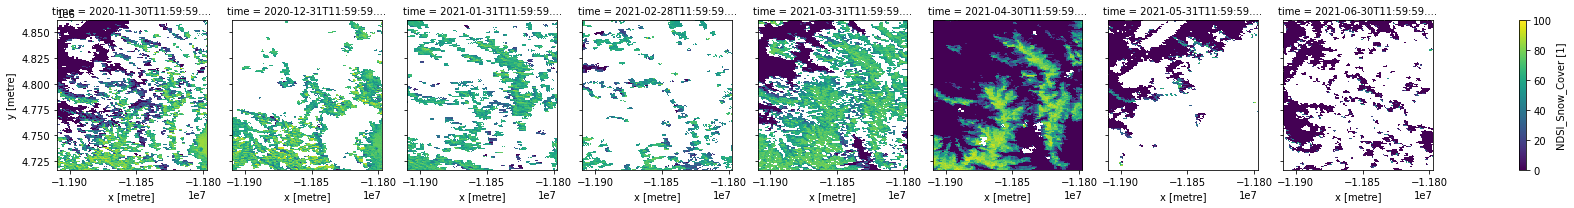

In [44]:
data["NDSI_Snow_Cover"].plot.imshow(col="time", vmin=0, vmax=100)

You'll notice there's a lot of missing values due to masking, probably due to clouds.
More sophisticated analysis would use the `NDSI_Snow_Cover_Basic_QA` and other bands to merge information from multiple scenes, or pick the best scenes for analysis.

### Data pages

These pages include links to the user guides:

- MOD10A1: https://nsidc.org/data/MOD10A1/versions/61
- MOD10A2: https://nsidc.org/data/MOD10A2/versions/61